<a href="https://colab.research.google.com/github/xelothi/ML-for-kinase-inhibitors-development/blob/main/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 60.9 MB/s eta 0:00:00


In [ ]:
! pip install padelpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 47.0 MB/s eta 0:00:00


In [ ]:
! pip install tabulate

In [ ]:
! wget https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip
! unzip fingerprints_xml.zip

--2023-09-15 00:59:09--  https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip [following]
--2023-09-15 00:59:09--  https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10871 (11K) [application/zip]
Saving to: ‘fingerprints_xml.zip’

fingerprints_xml.zi 100%[===================>]  10.62K  --.-KB/s    in 0s      

2023-09-15 00:59:09 (129 MB/s) - ‘fingerprints_xml.zip’ saved [10871/10871]

Archive:  fingerprints_xml

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score,r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
import glob
import os
from collections import defaultdict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection  import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pylab as py
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

In [ ]:
df = pd.read_csv("CRAF_confidence_score.csv", index_col=[0])
df = df.dropna()
df.rename(columns={"molecule_chembl_id": "Name"}, inplace=True)


In [ ]:
df

,Name,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity
0,CHEMBL18754,CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,345.468,4.35762,3.0,3.0,3.0,4900.0,5.309804,active
1,CHEMBL279560,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1,348.424,4.18180,3.0,5.0,3.0,15000.0,4.823909,active
2,CHEMBL95114,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1,364.471,4.25360,2.0,6.0,4.0,16000.0,4.795880,active
3,CHEMBL279377,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,346.452,4.78462,2.0,4.0,3.0,1700.0,5.769551,active
4,CHEMBL95692,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,353.401,3.07930,1.0,6.0,4.0,50.0,7.301030,inactive
...,...,...,...,...,...,...,...,...,...,...
587,CHEMBL3974325,Cc1ccc(C(=O)Nc2ccc(Cl)c(C(F)(F)F)c2)cc1NC(=O)c...,498.892,6.30222,3.0,4.0,4.0,10.7,7.970616,inactive
588,CHEMBL3944893,CCN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(NC(=O)c4cccc5c(...,646.758,7.41452,3.0,6.0,8.0,6.4,8.193820,inactive
589,CHEMBL3955345,Cc1ccc(C(=O)Nc2ccccc2)cc1NC(=O)c1cccc2c(NC(C)(...,452.558,6.25822,3.0,4.0,5.0,20.5,7.688246,inactive
590,CHEMBL3980795,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(NC(=O)c4cccc5c(N)n...,544.537,6.14294,3.0,6.0,5.0,94.8,7.023192,inactive


In [ ]:
xml_files = glob.glob("*.xml") #return file paths named .xml
xml_files.sort()
xml_files

['AtomPairs2DFingerprintCount.xml',
 'AtomPairs2DFingerprinter.xml',
 'EStateFingerprinter.xml',
 'ExtendedFingerprinter.xml',
 'Fingerprinter.xml',
 'GraphOnlyFingerprinter.xml',
 'KlekotaRothFingerprintCount.xml',
 'KlekotaRothFingerprinter.xml',
 'MACCSFingerprinter.xml',
 'PubchemFingerprinter.xml',
 'SubstructureFingerprintCount.xml',
 'SubstructureFingerprinter.xml']

In [ ]:
#create a list and assign them to the xml files( to compute descriptors)
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [ ]:
fp = dict(zip(FP_list, xml_files)) #create a dictionary of all..
fp

{'AtomPairs2DCount': 'AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'AtomPairs2DFingerprinter.xml',
 'EState': 'EStateFingerprinter.xml',
 'CDKextended': 'ExtendedFingerprinter.xml',
 'CDK': 'Fingerprinter.xml',
 'CDKgraphonly': 'GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'KlekotaRothFingerprinter.xml',
 'MACCS': 'MACCSFingerprinter.xml',
 'PubChem': 'PubchemFingerprinter.xml',
 'SubstructureCount': 'SubstructureFingerprintCount.xml',
 'Substructure': 'SubstructureFingerprinter.xml'}

In [ ]:
selection = ["Name", "std_smiles"]
df2 = df[selection]
df2

,Name,std_smiles
0,CHEMBL18754,CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1
1,CHEMBL279560,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1
2,CHEMBL95114,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1
3,CHEMBL279377,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1
4,CHEMBL95692,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1
...,...,...
587,CHEMBL3974325,Cc1ccc(C(=O)Nc2ccc(Cl)c(C(F)(F)F)c2)cc1NC(=O)c...
588,CHEMBL3944893,CCN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(NC(=O)c4cccc5c(...
589,CHEMBL3955345,Cc1ccc(C(=O)Nc2ccccc2)cc1NC(=O)c1cccc2c(NC(C)(...
590,CHEMBL3980795,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(NC(=O)c4cccc5c(N)n...


In [ ]:
df2 = pd.concat( [df['std_smiles'],df['Name']], axis=1 )
df2.to_csv('molecule.smi', sep='\t', index=False, header=False)
df2

,std_smiles,Name
0,CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,CHEMBL18754
1,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1,CHEMBL279560
2,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1,CHEMBL95114
3,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,CHEMBL279377
4,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,CHEMBL95692
...,...,...
587,Cc1ccc(C(=O)Nc2ccc(Cl)c(C(F)(F)F)c2)cc1NC(=O)c...,CHEMBL3974325
588,CCN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(NC(=O)c4cccc5c(...,CHEMBL3944893
589,Cc1ccc(C(=O)Nc2ccccc2)cc1NC(=O)c1cccc2c(NC(C)(...,CHEMBL3955345
590,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(NC(=O)c4cccc5c(N)n...,CHEMBL3980795


In [ ]:
from padelpy import padeldescriptor

for key in fp.keys():
    fingerprint_output_file = f'{key}.csv' #Substructure.csv
    fingerprint_descriptortypes = fp[key]
    padeldescriptor(mol_dir='molecule.smi',
                    d_file=fingerprint_output_file, #'Substructure.csv'
                    #descriptortypes='SubstructureFingerprint.xml',
                    descriptortypes= fingerprint_descriptortypes,
                    detectaromaticity=True,
                    standardizenitro=True,
                    standardizetautomers=True,
                    threads=4,
                    removesalt=True,
                    log=True,
                    fingerprints=True)

descriptor = pd.DataFrame(eval(fingerprint_output_file))
output = descriptor.to_csv(f"{descriptor}_output_file.csv")

NameError: ignored

In [ ]:
AtomPairs2D = pd.read_csv("AtomPairs2D.csv", header=0)
AtomPairs2DCount = pd.read_csv("AtomPairs2DCount.csv", header=0)
CDK = pd.read_csv("CDK.csv", header=0)
CDKextended = pd.read_csv("CDKextended.csv", header=0)
CDKgraphonly = pd.read_csv("CDKgraphonly.csv", header=0)
EState = pd.read_csv("EState.csv", header=0)
KlekotaRoth = pd.read_csv("KlekotaRoth.csv", header=0)
KlekotaRothCount = pd.read_csv("KlekotaRothCount.csv", header=0)
PubChem = pd.read_csv("PubChem.csv", header=0)
MACCS = pd.read_csv("MACCS.csv", header=0)
SubstructureCount = pd.read_csv("SubstructureCount.csv", header=0)
Substructure = pd.read_csv("Substructure.csv", header=0)

In [ ]:
def normalized(Fp):
    Name = Fp['Name']
    Fp_ix = Fp.iloc[:, 1:]
    min_max_scaler = MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(Fp_ix)
    Fp_normalized = pd.DataFrame(np_scaled, columns=Fp_ix.columns)
    Fp_normalized['Name'] = Name

    return Fp_normalized


In [ ]:
atom_pairs_2D_norm = normalized(AtomPairs2D)
atom_pairs_2D_count_norm = normalized(AtomPairs2DCount)
CDK_norm = normalized(CDK)
CDK_extended_norm = normalized(CDKextended)
CDK_graphonly_norm = normalized(CDKgraphonly)
EState_norm = normalized(EState)
Klekota_roth_norm = normalized(KlekotaRoth)
Klekota_roth_count_norm = normalized(KlekotaRothCount)
PubChem_norm = normalized(PubChem)
substrucutre_norm = normalized(Substructure)
substrucutre_count_norm = normalized(SubstructureCount)
MACCS_norm = normalized(MACCS)


In [ ]:
atom_pairs_2D_norm.to_csv("AtomPairs2D_normalized.csv", sep=',' ,index=False)
atom_pairs_2D_count_norm.to_csv("AtomPairs2DCount_normalized.csv", sep=',' ,index=False)
CDK_norm.to_csv("CDK_normalized.csv", sep=",", index=False)
CDK_extended_norm.to_csv("CDKextened_normalized.csv", sep=",", index=False)
CDK_graphonly_norm.to_csv("CDK_graphonly_normalized.csv", sep=",", index=False)
EState_norm.to_csv("EState_normalized.csv", sep=",", index=False)
Klekota_roth_norm.to_csv("KlekotaRoth_nomralized.csv", sep=",", index=False)
Klekota_roth_count_norm.to_csv("KlekotaRothCount_normalized.csv", sep=",", index=False)
PubChem_norm.to_csv("PubChem_normalized.csv", sep=",", index=False)
substrucutre_norm.to_csv("Substructure_normalized.csv", sep=",", index=False)
substrucutre_count_norm.to_csv("SubstrucutreCount_normalized.csv", sep=",", index=False)
MACCS_norm.to_csv("MACCS_normalized.csv", sep=",", index=False)

NameError: ignored

In [ ]:
def remove_useless_descriptors(input_df, stdev_threshold):
    initial_descriptor_count = len(input_df.columns)

    descriptor_names = input_df.columns.tolist()
    data_values = input_df.values.astype(float)
    descriptor_matrix = np.array(data_values)

    standard_deviations = np.std(descriptor_matrix, axis=0)
    indices_to_keep = [idx for idx, std_dev in enumerate(standard_deviations) if std_dev > stdev_threshold]
    new_descriptor_matrix = descriptor_matrix[:, indices_to_keep]
    remaining_descriptor_names = np.array(descriptor_names)[indices_to_keep]

    new_df = pd.DataFrame(new_descriptor_matrix, columns=[remaining_descriptor_names])

    final_descriptor_count = len(new_df.columns)

    print('Removing useless descriptors')
    print('-------------------------------------------------------------------------')
    print(f'The initial set of {initial_descriptor_count} descriptors has been reduced to {final_descriptor_count} descriptors.')

    return new_df
def remove_highly_correlated_descriptors(data, correlation_threshold):

    initial_descriptor_count = len(data.columns)
    correlation_function = stats.pearsonr
    correlated_column_names = set()

    correlation_matrix = data.corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if correlation_matrix.iloc[i, j] >= correlation_threshold:
                column_name = correlation_matrix.columns[i]  # Getting the name of the column
                correlated_column_names.add(column_name)
                if column_name in data.columns:
                    del data[column_name]  # Deleting the column from the dataset

    final_descriptor_count = len(data.columns)

    print('Removing highly correlated descriptors')
    print('-------------------------------------------------------------------------')
    print(f'The initial set of {initial_descriptor_count} descriptors has been reduced to {final_descriptor_count} descriptors.')

    return data

In [206]:

def perform_y_scrambling(X_train, X_test, y_train, y_test):

    for random_seed_counter in range(1, 101):
        # Create shuffled copies of the training labels and features
        y_train_shuffled = deepcopy(y_train)

        np.random.shuffle(y_train_shuffled)

        # Train a RandomForestRegressor on the shuffled data
        rf_scrambled = RandomForestRegressor()
        rf_scrambled = rf_scrambled.fit(X_train, y_train_shuffled)

        # Predictions on the test set
        y_predict_test = rf_scrambled.predict(X_test)
        r2_test_scramble = (rf_scrambled.score(X_test, y_test))**2
        r2_scores_test_scrambled.append(r2_test_scramble)

        # Predictions on the train set
        y_predict_train = rf_scrambled.predict(X_train)
        r2_train_scramble =  (rf_scrambled.score(X_train, y_train))**2
        r2_scores_train_scrambled.append(r2_train_scramble)

    return r2_scores_test_scrambled, r2_scores_train_scrambled

In [ ]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):

    fig, ax = plt.subplots()

    # Below for loop iterates through models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")



In [ ]:
def metrics(R2_train, RMSE_train, Q2_CV, RMSE_CV, Q2_External, RMSE_External, importances_dict):
    R2_train_mean = np.mean(R2_train)
    RMSE_train_mean = np.mean(RMSE_train)
    Q2_CV_mean = np.mean(Q2_CV)




    RMSE_CV_mean = np.mean(RMSE_CV)
    Q2_External_mean = np.mean(Q2_External)
    RMSE_External_mean = np.mean(RMSE_External)

    R2_train_std = np.std(R2_train)
    RMSE_train_std = np.std(RMSE_train)
    Q2_CV_std = np.std(Q2_CV)
    RMSE_CV_std = np.std(RMSE_CV)
    Q2_External_std = np.std(Q2_External)
    RMSE_External_std = np.std(RMSE_External)


    importances_mean0 = {}
    for fx in importances_dict:
        importances_mean0[fx] = np.mean(importances_dict[fx])
    importances_mean = sorted([(k,v) for k,v in importances_mean0.items()],
                                     key=lambda x: x[1], reverse=True)

    importances_std0 = {}
    for fx in importances_dict:
        importances_std0[fx] = np.std(importances_dict[fx])
    importances_std = sorted([(k,v) for k,v in importances_std0.items()],
                                     key=lambda x: x[1], reverse=True)


    return R2_train_mean, RMSE_train_mean, Q2_CV_mean, RMSE_CV_mean, Q2_External_mean, RMSE_External_mean, R2_train_std, RMSE_train_std, Q2_CV_std, RMSE_CV_std, Q2_External_std, RMSE_External_std, importances_mean, importances_std

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from sklearn.metrics import r2_score

def plot_model(fp_file, splits, ml_model,
              R2_train_mean, Q2_External_mean,
              importances_mean, importances_std, Feature, prediction_train,
              r2_scores_test_scrambled, r2_scores_train_scrambled):

    X_train, X_test, y_train, y_test = splits
    # Set figure size
    model = ml_model.fit(X_train, y_train)

    plt.figure(figsize=(10, 10))
    cm = plt.cm.RdBu
    cv = cross_val_predict(ml_model, X_train, y_train, cv=10, n_jobs=-1)
    # Train Set
    y_train_pred = model.predict(X_train).flatten()
    plt.scatter(y_train, y_train_pred, s=50, marker='.', alpha=0.3,
                c='purple', edgecolors='purple', label=f"$R^2_{{Tr}}$ = {R2_train_mean:.4f}")

    # CV Set
    y_cv_pred = cv
    plt.scatter(y_train, y_cv_pred, s=50, marker='.', alpha=0.3,
                c='orange', edgecolors='orange', label=f"$Q^2_{{Ext}}$ = {Q2_External_mean:.4f}")

    # 2SD line
    X = sm.add_constant(y_train)
    res = sm.OLS(y_cv_pred, X).fit()
    st, data, ss2 = summary_table(res, alpha=0.05)
    predict_ci_low, predict_ci_upp = data[:, 6:8].T
    plt.plot(y_train, predict_ci_low, '--b', linewidth=0.5, alpha=0.5)
    plt.plot(y_train, predict_ci_upp, '--b', linewidth=0.5, alpha=0.5)

    # External Set
    y_external_pred = ml_model.predict(X_test).flatten()
    plt.scatter(y_test, y_external_pred, s=50, marker='.', alpha=0.3,
                c='green', edgecolors='green', label=f"$Q^2_{{Ext}}$ = {Q2_External_mean:.4f}")

    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.legend(loc=2, prop={'size': 6})

    min_axis = np.min(np.concatenate([y_train, y_train_pred, y_external_pred], axis=0))
    max_axis = np.max(np.concatenate([y_train, y_train_pred, y_external_pred], axis=0))
    plt.xlim([(min_axis * 0.9), (max_axis * 1.05)])
    plt.ylim([(min_axis * 0.9), (max_axis * 1.05)])
    plt.tick_params(axis='both', which='major', labelsize=14)

    # Save plot to file
    plt.savefig(f'{fp_file}_compair_Fp.pdf', dpi=300)
    plt.show()

    # Y-scrambling plot
    plt.figure(figsize=(5, 5))
    plt.scatter(Q2_External_mean, R2_train_mean, s=100, marker='.', alpha=0.3,
                c='blue', edgecolors='blue', label="$Q^{2}$ vs. $R^{2}$ (CV)")

    plt.scatter(r2_scores_test_scrambled, r2_scores_train_scrambled,
                s=100, marker='.', alpha=0.3, c='red', edgecolors='red',
                label="Y-scrambling")

    plt.xlabel("$Q^{2}$", fontsize=10)
    plt.ylabel("$R^{2}$", fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.axhline(0.5, color='gray', linestyle='--', dashes=(5, 10), linewidth=0.5)
    plt.axvline(0.5, color='gray', linestyle='--', dashes=(5, 10), linewidth=0.5)
    plt.legend(loc=2, prop={'size': 6})
    plt.savefig(f'{fp_file}_Y_scrambling.pdf', dpi=300)
    plt.show()

    # Feature Importance
    plt.figure(figsize=(5, 10))
    barlist = plt.barh(range(20), [x[1] for x in importances_mean[:20]],
                      color="cyan", xerr=[x[1] for x in importances_std[:20]], align="center",
                      error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

    print("top10", [x[0] for x in importances_mean[:10]])
    print("top20", [x[0] for x in importances_mean[:20]])
    print("top30", [x[0] for x in importances_mean[:30]])
    print("top40", [x[0] for x in importances_mean[:40]])
    print("top50", [x[0] for x in importances_mean[:50]])

    plt.yticks(range(20), [x[0] for x in importances_mean[:20]])
    plt.ylim([-1, 20])
    plt.xlabel(r"Gini Index", fontsize=12)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.tight_layout(pad=2.0, w_pad=0.7, h_pad=2.0)
    plt.savefig(f'{fp_file}_Feature_importances.pdf', dpi=300)
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = "/content/gdrive/MyDrive/improved_fp/"

In [ ]:
def extract_file_name(file_path):
    # Extract the file name without extension
    file_name = os.path.basename(file_path)
    file_name_without_extension = os.path.splitext(file_name)[0]
    return file_name_without_extension


In [224]:
def model_performance(y_train,y_test, prediction, cv, prediction_external):
    R2_train.append(r2_score(y_train, prediction))
    RMSE_train.append(np.sqrt(mean_absolute_error(y_train, prediction)))
    Q2_cross_val.append(r2_score(y_train, cv))
    RMSE_cross_val.append(np.sqrt(mean_absolute_error(y_train, cv)))
    Q2_ext.append(r2_score(y_test, prediction_external))
    RMSE_ext.append((mean_absolute_error(y_test, prediction_external)))

In [228]:
def model_training_and_validation(X,Y,seed, hx, verbose=True):


    #Data split using 70/30 ratio
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        Y, test_size=0.3,
                                                        random_state=seed)
    param = {
    "n_estimators": 400, # number of trees to grows
    "max_features": "sqrt",
    "min_samples_leaf": 1,
    "criterion": "squared_error",
    "n_jobs": -1  # cost function to be optimized for a split
    }
    # Training set
    model_RF = RandomForestRegressor(random_state=SEED, **param)

    model_RF.fit(X_train,y_train)
    prediction = model_RF.predict(X_train)

    # Cross-validation
    cv = cross_val_predict(model_RF, X_train, y_train, cv=10, n_jobs=-1)

    # External set
    prediction_external = model_RF.predict(X_test)

    #print result from each seed
    model_performance(y_train,y_test, prediction, cv, prediction_external)

    #Feature Importance
    Feature = hx[:]
    feature_importance = model_RF.feature_importances_
    importances = 100.0 * (feature_importance / feature_importance.max()) #index

    for i, fx in enumerate(Feature):
        importances_dict[str(fx)].append(importances[i])


    return Feature, X_train, X_test, y_train, y_test, importances_dict

----------------------------------------------------------------------------------------------
AtomPairs2DCount_normalized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 780 descriptors has been reduced to 262 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 262 descriptors has been reduced to 107 descriptors.
+----------------------+----------+
| Metric               | Value    |
+======================+==========+
| Training set         |          |
+----------------------+----------+
| N                    | 411      |
+----------------------+----------+
| R2                   | 0.9569   |
+----------------------+----------+
| std_R2               | 0.003342 |
+----------------------+----------+
| RMSE                 | 0.4790   |
+----------------------+---------

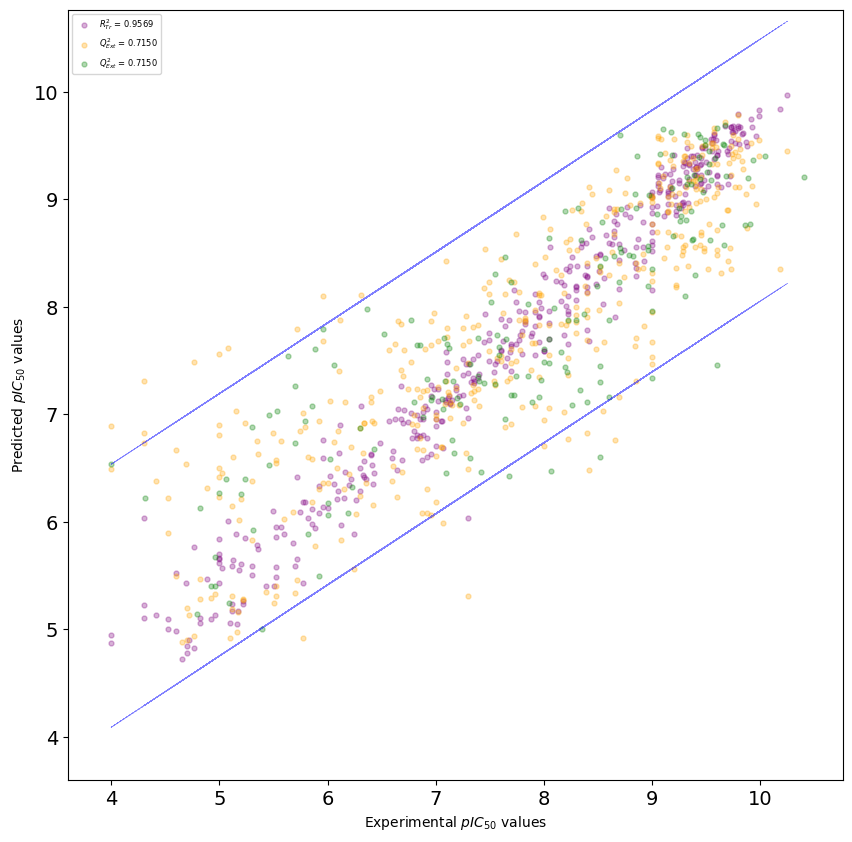

<ipython-input-107-adf5fc983e61>:58: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Q2_External_mean, R2_train_mean, s=100, marker='.', alpha=0.3,


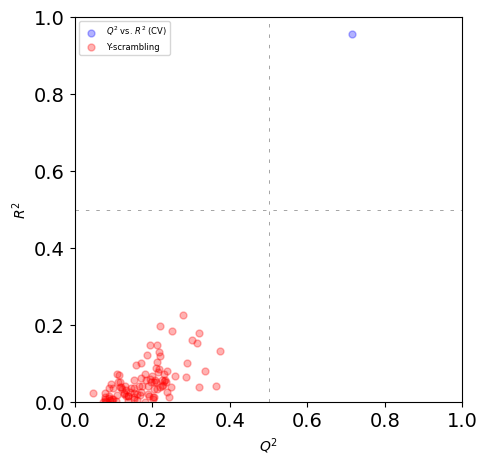

top10 ["['APC2D1_C_C']", "['APC2D1_C_N']", "['APC2D9_N_O']", "['APC2D8_C_O']", "['APC2D3_N_O']", "['APC2D4_N_O']", "['APC2D7_C_N']", "['APC2D1_C_F']", "['APC2D2_N_O']", "['APC2D7_C_O']"]
top20 ["['APC2D1_C_C']", "['APC2D1_C_N']", "['APC2D9_N_O']", "['APC2D8_C_O']", "['APC2D3_N_O']", "['APC2D4_N_O']", "['APC2D7_C_N']", "['APC2D1_C_F']", "['APC2D2_N_O']", "['APC2D7_C_O']", "['APC2D10_N_O']", "['APC2D1_C_O']", "['APC2D7_N_O']", "['APC2D7_O_O']", "['APC2D6_O_O']", "['APC2D2_N_N']", "['APC2D9_N_N']", "['APC2D5_O_O']", "['APC2D6_N_O']", "['APC2D10_N_N']"]
top30 ["['APC2D1_C_C']", "['APC2D1_C_N']", "['APC2D9_N_O']", "['APC2D8_C_O']", "['APC2D3_N_O']", "['APC2D4_N_O']", "['APC2D7_C_N']", "['APC2D1_C_F']", "['APC2D2_N_O']", "['APC2D7_C_O']", "['APC2D10_N_O']", "['APC2D1_C_O']", "['APC2D7_N_O']", "['APC2D7_O_O']", "['APC2D6_O_O']", "['APC2D2_N_N']", "['APC2D9_N_N']", "['APC2D5_O_O']", "['APC2D6_N_O']", "['APC2D10_N_N']", "['APC2D5_N_O']", "['APC2D10_O_O']", "['APC2D8_N_O']", "['APC2D4_N_N']", "[

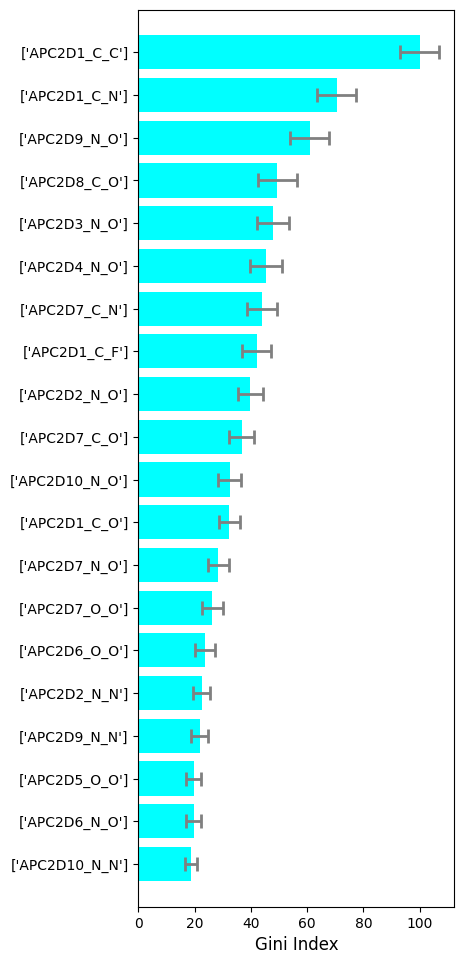

----------------------------------------------------------------------------------------------
AtomPairs2D_normalized
---------------------------------------------------
Removing useless descriptors
-------------------------------------------------------------------------
The initial set of 780 descriptors has been reduced to 248 descriptors.
Removing highly correlated descriptors
-------------------------------------------------------------------------
The initial set of 248 descriptors has been reduced to 109 descriptors.


KeyboardInterrupt: ignored

In [229]:
from tabulate import tabulate

SEED = 13

for fp_file in glob.glob(f'{path}*.csv'):
    # Extract the file name without extension
    model_name = extract_file_name(fp_file)
    print("----------------------------------------------------------------------------------------------")
    print(model_name)
    print("---------------------------------------------------")


    df_fp = pd.read_csv(fp_file)
    df_fp = df_fp.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    df_fp = df_fp.fillna(method='ffill')
    data = df_fp.iloc[:, :-1]
    Y = df["pIC50"].values.astype(float)
    data = remove_useless_descriptors(data, 0.05)  # Remove correlation cut off 95%
    data = remove_highly_correlated_descriptors(data, 0.7)  # Remove correlation cut off 0.7


    h = data.columns.tolist()
    hx = np.array(h)

    data = data.values.astype(float)
    X = np.array(data)

    # Prepare empty lists to plot QSAR model
    R2_train = []
    RMSE_train = []
    Q2_cross_val = []
    RMSE_cross_val = []
    Q2_ext = []
    RMSE_ext = []
    prediction_train = []
    importances_dict = defaultdict(list)

    # Prepare empty lists to plot the performance of accuracy.
    r2_scores_train_scrambled= []
    r2_scores_test_scrambled = []



    # Perform model training and validation using the model_name
    for i in range(10):
         Feature, X_train, X_test, y_train, y_test,importances_dict = model_training_and_validation(X, Y, i, hx)

    r2_scores_train_scrambled, r2_scores_test_scrambled =  perform_y_scrambling(X_train, X_test, y_train, y_test)

    R2_train_mean, RMSE_train_mean, Q2_CV_mean, RMSE_CV_mean, Q2_External_mean, RMSE_External_mean, R2_train_std, RMSE_train_std, Q2_CV_std, RMSE_CV_std, Q2_External_std, RMSE_External_std, importances_mean, importances_std = metrics(R2_train, RMSE_train,Q2_cross_val,RMSE_cross_val, Q2_ext,RMSE_ext, importances_dict)

    metrics_table = [
    ['Metric', 'Value'],
    ['Training set', ''],
    ['N', f'{len(X_train)}'],
    ['R2', f'{R2_train_mean:.4f}'],
    ['std_R2', f'{R2_train_std:.6f}'],
    ['RMSE', f'{RMSE_train_mean:.4f}'],
    ['std_RMSE', f'{RMSE_train_std:.6f}'],
    ['', ''],
    ['Cross-validation set', ''],
    ['N', f'{len(X_train)}'],
    ['Q2', f'{Q2_CV_mean:.4f}'],
    ['std_Q2', f'{Q2_CV_std:.6f}'],
    ['RMSE', f'{RMSE_CV_mean:.4f}'],
    ['std_RMSE', f'{RMSE_CV_std:.6f}'],
    ['', ''],
    ['External set', ''],
    ['N', f'{len(X_test)}'],
    ['Q2_EXt', f'{Q2_External_mean:.4f}'],
    ['std_Q2_EXt', f'{Q2_External_std:.6f}'],
    ['RMSE', f'{RMSE_External_mean:.4f}'],
    ['std_RMSE', f'{RMSE_External_std:.6f}']]
    print(tabulate(metrics_table, headers='firstrow', tablefmt='grid'))
    plot_model(fp_file,splits, model_RF,R2_train_mean, Q2_External_mean,importances_mean, importances_std, Feature, prediction_train,
                r2_scores_test_scrambled, r2_scores_train_scrambled)
